# Open Street Map

By making use of the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library we can fetch [OpenStreetMap](https://www.openstreetmap.org/) data and use it in MGSurvE! This time, we will start by loading the library and setting up some of its internal parameters:

In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
from copy import deepcopy
from math import exp
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
import cartopy.crs as ccrs
ox.settings.log_console=False
ox.settings.use_cache=True


Bad key text.latex.preview in file /Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

## Downloading Buildings Footprints

In this example, we will download the data of a section of Banfora, Burkina Faso. To do this, we will center our reference point at the `(110.63524, -4.75195)` coordinates and set an altitude of `250` meters:

In [2]:
(COORDS, DIST) = ((10.63524, -4.75195), 250)
# Scrape building footprints to dataframe -------------------------------------
BLD = ox.features.features_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/e

The `BLD` dataframe contains all the information we need to generate a map of the location and we can, additionally, plot the roads by projecting the `NTW` graph:

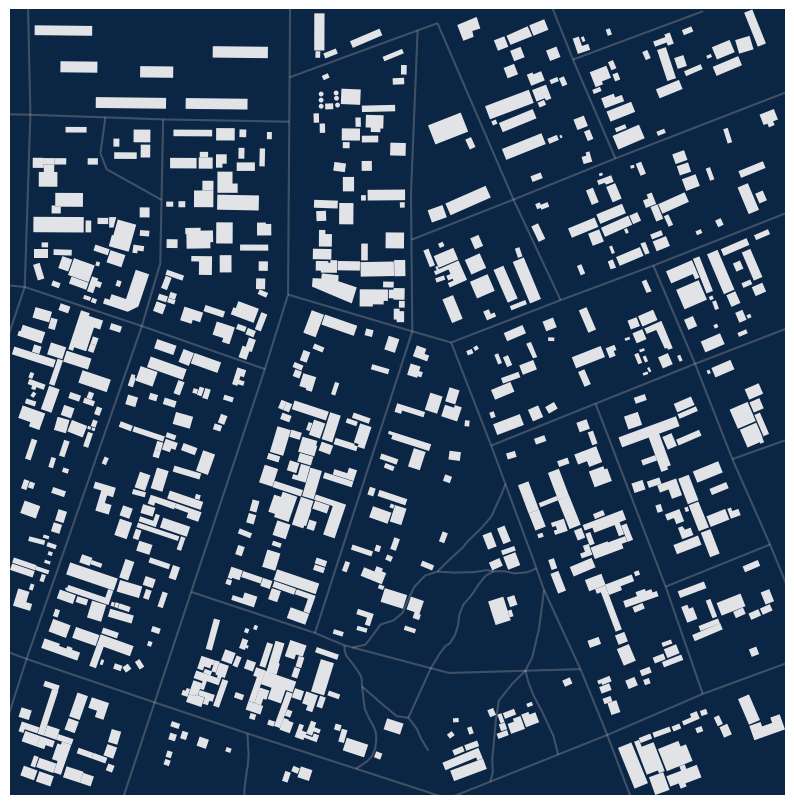

In [3]:
STYLE_BG = {'color': '#0b2545'}
STYLE_BD = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
# Project and plot map --------------------------------------------------------
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

## Generating MGSurvE Landscape

If we wanted to make use of our data in MGSurvE, one simple way we can go about it is by using the `centroid_lon` and `centroid_lat` to generate our migration matrix and landscape:

In [4]:
lonLats = np.array(list(zip(BLD['centroid_lon'], BLD['centroid_lat'])))
migDst = srv.calcDistanceMatrix(lonLats, distFun=srv.haversineDistance)

In [5]:
def exponentialKernel(distMat, decay):
    coordsNum = len(distMat)
    migrMat = np.empty((coordsNum, coordsNum))
    for (i, row) in enumerate(distMat):
        for (j, dst) in enumerate(row):
            migrMat[i][j] = exp(-decay*dst)
        for j in range(len(row)):
            if np.isnan(migrMat[i][j]):
                migrMat[i][j] = 0
    tauN = normalize(migrMat, axis=1, norm='l1')
    return tauN
# 
MEAN_DISPERSAL = 25
migMat = exponentialKernel(migDst, 1/MEAN_DISPERSAL)

In [6]:
sites = pd.DataFrame(lonLats, columns=['lon', 'lat'])
sites['t'] = [0]*sites.shape[0]

BBOX = (
    (min(sites['lon']), max(sites['lon'])),
    (min(sites['lat']), max(sites['lat']))
)
CNTR = [i[0]+(i[1]-i[0])/2 for i in BBOX]

In [7]:
TRPS_NUM = 5
(initLon, initLat) = (COORDS[0]*TRPS_NUM, COORDS[1]*TRPS_NUM)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': [0]*TRPS_NUM, 'f': [0]*TRPS_NUM
})
tKer = {0:{'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

In [8]:
lnd = srv.Landscape(
    sites, migrationMatrix=migMat,
    traps=traps, trapsKernels=tKer, landLimits=BBOX,
    trapsRadii=[0.250, 0.125, 0.100],
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

## Optimizing 

In [9]:
GENS = 250
VERBOSE = True
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
lndGA = deepcopy(lnd)
# Reducing the bbox for init sampling -----------------------------------------
redFract = .25
reduction = [(i[1]-i[0])/2*redFract for i in bbox]
bboxRed = [(i[0]+r, i[1]-r) for (i, r) in zip(bbox,reduction)]
###############################################################################
# Registering GA functions
############################################################################### 
outer = np.mean
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lndGA, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': outer}
)

gen	nevals	min    	avg    	max    	std    	best	traps                    
0  	75    	31.6729	50.2366	124.961	15.6197	36  	[473, 210, 436, 608, 124]
1  	43    	31.0481	43.7709	92.2632	8.97914	66  	[589, 473, 340, 243, 69] 
2  	45    	31.0481	41.1265	76.4982	9.47041	68  	[589, 473, 340, 243, 69] 
3  	39    	31.0481	37.7996	56.4152	5.76691	8   	[589, 473, 340, 243, 69] 
4  	38    	30.6906	37.4641	62.895 	6.45527	63  	[297, 411, 616, 467, 677]
5  	34    	29.7807	35.9963	56.9898	6.11342	23  	[132, 473, 340, 239, 23] 
6  	51    	28.2868	36.3594	64.0977	7.03636	61  	[132, 473, 646, 239, 23] 
7  	46    	28.2868	36.9322	78.957 	9.96151	0   	[132, 473, 646, 239, 23] 
8  	48    	28.2868	37.0256	70.7752	7.98544	64  	[132, 473, 646, 239, 23] 
9  	36    	28.1688	34.897 	54.5511	6.16319	63  	[132, 473, 303, 629, 69] 
10 	50    	28.1688	35.4583	57.6623	7.15294	5   	[132, 473, 303, 629, 69] 
11 	40    	27.4736	34.9789	69.7344	8.57534	1   	[132, 473, 498, 239, 23] 
12 	45    	27.4736	35.8666	65.9827	7.9

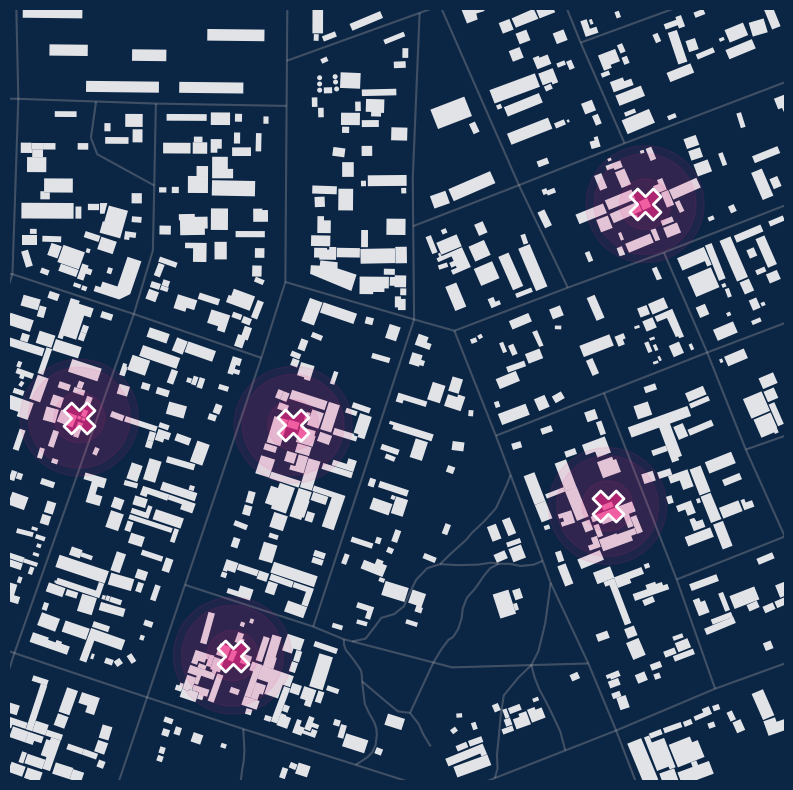

In [10]:
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lnd.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])